In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [19]:
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv',
                            parse_dates=[3])

test_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv',
                           parse_dates=[3])
df = pd.concat([train_features, test_features], axis = 0)


df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']


total_cases = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')
sj_cases = total_cases[total_cases['city'] == 'sj']['total_cases']
iq_cases = total_cases[total_cases['city'] == 'iq']['total_cases']


df_sj.set_index('week_start_date', drop = True, inplace = True)
df_iq.set_index('week_start_date', drop = True, inplace = True)


df_sj.drop(['city', 'year'], axis = 1, inplace = True)
df_iq.drop(['city', 'year'], axis = 1, inplace = True)

df_sj.index

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [20]:


# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = sj_cases[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = sj_cases[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test

print len(sj_train), len(sj_Xtrain), len(sj_ytrain)
print len(sj_valid), len(sj_Xvalid), len(sj_yvalid)
print len(sj_test), len(sj_Xtest)



675 675 675
261 261 261
260 260


In [21]:


#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_trainX = iq_train
iq_trainY = iq_cases[:len(iq_trainX)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = iq_cases[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test

# check the lengths
print len(iq_train), len(iq_trainX), len(iq_trainY)
print len(iq_valid), len(iq_Xvalid), len(iq_yvalid)
print len(iq_test), len(iq_Xtest)



364 364 364
156 156 156
156 156


In [0]:


from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV



In [0]:
#set up training data
months = pd.get_dummies(sj_Xtrain['month'], prefix='month')
weather = sj_Xtrain.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

In [24]:
# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, sj_ytrain)  
gs.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.5min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=12,
       min_child_weight=6, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

17.729921049541897
0.05543821948553607


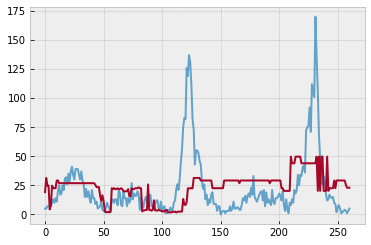

In [25]:
months = pd.get_dummies(sj_Xvalid['month'], prefix='month')
weather = sj_Xvalid.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
valid = pd.concat([months, weather, weather2], axis = 1)

# make and plot predictions, scores
preds = pd.Series(gs.predict(valid))
# preds = preds.rolling(2, min_periods=1, center = True).mean()
plt.plot(sj_yvalid.values, alpha = .75)
plt.plot(preds)
print mean_absolute_error(preds, sj_yvalid.values)
print gs.score(valid, sj_yvalid)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  2.1min finished


0.1721381578661445


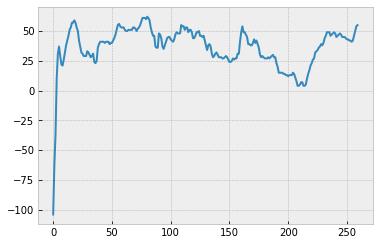

In [26]:
#set up training data
sj_Xtrain2 = pd.concat([sj_Xtrain, sj_Xvalid], axis = 0)
sj_ytrain2 = pd.concat([sj_ytrain, sj_yvalid], axis = 0)
months = pd.get_dummies(sj_Xtrain2['month'], prefix='month')
weather = sj_Xtrain2.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, sj_ytrain2)  
gs.best_estimator_

months = pd.get_dummies(sj_Xtest['month'], prefix='month')
weather = sj_Xtest.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
test = pd.concat([months, weather, weather2], axis = 1)

# make predictions
sj_cases_predictions = pd.Series(gs.predict(test))
sj_cases_predictions = sj_cases_predictions.rolling(3, min_periods=1).mean().apply(lambda x: int(x))

# plot
plt.plot(sj_cases_predictions)
print gs.score(train, sj_ytrain2)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.2min finished
/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.0790090871752127


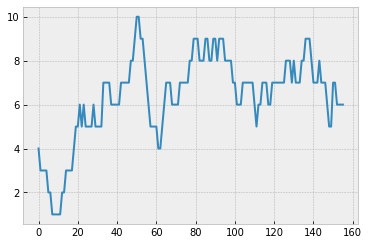

In [27]:
#set up training data
iq_trainX2 = pd.concat([iq_trainX, iq_Xvalid], axis = 0)
iq_trainY2 = pd.concat([iq_trainY, iq_yvalid], axis = 0)
months = pd.get_dummies(iq_trainX2['month'], prefix='month')
weather = iq_trainX2.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, iq_trainY2)  
gs.best_estimator_

months = pd.get_dummies(iq_Xtest['month'], prefix='month')
weather = iq_Xtest.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
test = pd.concat([months, weather, weather2], axis = 1)

# make predictions
iq_cases_predictions = pd.Series(gs.predict(test))
iq_cases_predictions = iq_cases_predictions.rolling(3, min_periods=1).mean().apply(lambda x: int(x))

# plot
plt.plot(iq_cases_predictions)
print gs.score(train, iq_trainY2)

In [28]:
sj_cases_predictions = sj_cases_predictions.apply(lambda x: 1 if x < 1 else int(x))
iq_cases_predictions = iq_cases_predictions.apply(lambda x: 0 if x < 1 else int(x))
total_predictions = list(sj_cases_predictions) + list(iq_cases_predictions)




#####
submission = pd.read_csv("https://s3.amazonaws.com/drivendata/data/44/public/submission_format.csv",index_col=[0, 1, 2])

submission['total_cases'] = total_predictions 
submission['total_cases'] = submission['total_cases'].apply(lambda x: int(x))

print(submission)
submission.to_csv("attempt1.csv")
from google.colab import files

files.download('attempt1.csv')



                      total_cases
city year weekofyear             
sj   2008 18                    1
          19                    1
          20                    1
          21                   10
          22                   31
          23                   37
          24                   29
          25                   22
          26                   21
          27                   26
          28                   32
          29                   38
          30                   42
          31                   46
          32                   51
          33                   53
          34                   57
          35                   57
          36                   59
          37                   57
          38                   53
          39                   50
          40                   42
          41                   37
          42                   32
          43                   31
          44                   29
          45  

In [29]:
submission.head()

total_cases
city year weekofyear             
sj   2008 18                    1
          19                    1
          20                    1
          21                   10
          22                   31